# ~ enviroment preparation

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from itertools import cycle, product
import pickle
# impute
from sklearn.impute import KNNImputer
from impyute.imputation.cs import mice
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1 Dataset preparation

In [99]:
# dev_csv_file = "knn_imputed_data.csv"  # <-- your data.csv path
# df0 = pd.read_csv(dev_csv_file)
# df0

,output,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,0,0.0,-1.8653,3.479344,47.8891,44.044274,9.0,10.0,39.0,21.0,...,0.862046,0.116831,0.560654,0.379450,0.268039,20.706840,52.049186,91.644726,0.793068,1.208143
1,0,0.0,-7.2263,52.219412,137.7680,88.208099,0.0,0.0,87.0,44.0,...,0.883822,0.065994,0.572409,0.487711,0.434117,42.761478,193.812432,465.446927,0.825733,1.494237
2,0,0.0,-2.1004,4.411680,67.0727,55.758204,6.0,6.0,52.0,24.0,...,0.910758,0.057143,0.494202,0.319559,0.386393,29.370226,71.693573,143.387359,0.866137,1.200154
3,0,0.0,-0.5179,0.268220,52.6108,46.640239,6.0,6.0,43.0,20.0,...,0.908190,0.048952,0.533958,0.387559,0.470449,24.128665,49.765298,100.659835,0.862285,1.391967
4,0,1.0,0.5703,0.325242,37.1534,45.496309,12.0,12.0,36.0,23.0,...,0.629985,0.333300,0.474489,0.401925,0.374420,15.580870,59.559927,104.301091,0.444977,1.250833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,1,0.0,-0.9977,0.995405,88.4810,74.525376,11.0,11.0,66.0,34.0,...,0.664985,0.275192,0.500426,0.451238,0.382046,21.066528,98.232335,206.338134,0.524004,1.333710
936,1,0.0,-0.9977,0.995405,88.4810,74.525376,11.0,11.0,66.0,34.0,...,0.664985,0.275192,0.500426,0.451238,0.382046,21.066528,98.232335,206.338134,0.524004,1.333710
937,1,0.0,-0.9977,0.995405,88.4810,74.525376,11.0,11.0,66.0,34.0,...,0.664985,0.275192,0.500426,0.451238,0.382046,21.066528,98.232335,206.338134,0.524004,1.333710
938,1,0.0,-0.9977,0.995405,88.4810,74.525376,11.0,11.0,66.0,34.0,...,0.664985,0.275192,0.500426,0.451238,0.382046,21.066528,98.232335,206.338134,0.524004,1.333710


## [TODO]
- feature engineering
- feature selection

In [101]:
df = pd.read_excel('OUTPUT.xlsx')

In [102]:

output = df['output']
data = df.drop(columns=['ID', 'name', 'smiles', 'output']).copy()
selected_features = data.columns

for column in data.columns:
    max_value = data[column][data[column] != np.inf].max()  # Calculate the maximum value excluding inf
    data[column].replace(np.inf, max_value, inplace=True)  # Replace inf with the maximum value

# 使用KNN補值原始資料的NaN
scaler = MinMaxScaler().fit(data)
scaled_df = scaler.transform(data)

# 使用KNN補值
knn_imputer = KNNImputer(n_neighbors=4).fit(scaled_df)
knn_imputed_df = knn_imputer.transform(scaled_df)

# 將補值後的資料還原為原始範圍
df0 = scaler.inverse_transform(knn_imputed_df)
df0 = pd.DataFrame(df0, columns=selected_features)
df0 = pd.concat([output, df0], axis=1)
df0.head(5)

,output,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,0,0.0,-1.8653,3.479344,47.8891,44.044274,9.0,10.0,39.0,21.0,...,0.862046,0.116831,0.560654,0.379450,0.268039,20.706840,52.049186,91.644726,0.793068,1.208143
1,0,0.0,-7.2263,52.219412,137.7680,88.208099,0.0,0.0,87.0,44.0,...,0.883822,0.065994,0.572409,0.487711,0.434117,42.761478,193.812432,465.446927,0.825733,1.494237
2,0,0.0,-2.1004,4.411680,67.0727,55.758204,6.0,6.0,52.0,24.0,...,0.910758,0.057143,0.494202,0.319559,0.386393,29.370226,71.693573,143.387359,0.866137,1.200154
3,0,0.0,-0.5179,0.268220,52.6108,46.640239,6.0,6.0,43.0,20.0,...,0.908190,0.048952,0.533958,0.387559,0.470449,24.128665,49.765298,100.659835,0.862285,1.391967
4,0,1.0,0.5703,0.325242,37.1534,45.496309,12.0,12.0,36.0,23.0,...,0.629985,0.333300,0.474489,0.401925,0.374420,15.580870,59.559927,104.301091,0.444977,1.250833


In [103]:
# # feature engineering
# # feature impute
# df0.loc[:, 'nAcid':] = df0.loc[:, 'nAcid':].replace([np.inf, -np.inf], np.nan)
# df0.loc[:, 'nAcid':] = df0.loc[:, 'nAcid':].fillna(0)  # just simple fill all NaN with 0

In [104]:
# feature selection

## Define model feature inputs(X) and target output(y)

In [105]:
# print(df0.loc[:, 'nAcid':].columns) # features

In [106]:
use_cols = df0.loc[:, 'nAcid':].columns.tolist()
# print(use_cols)

In [107]:
#@title check feature columns # 自行修改確認
#use_cols = ['AATS0e', 'AATS0i', 'AATS0m', 'AATS0p', 'AATS0s', 'AATS0v', 'AATS1e', 'AATS1i', 'AATS1m', 'AATS1p', 'AATS1s', 'AATS1v', 'AATS2e', 'AATS2i', 'AATS2m', 'AATS2p', 'AATS2s', 'AATS2v', 'AATS3e', 'AATS3i', 'AATS3m', 'AATS3p', 'AATS3s', 'AATS3v', 'AATS4e', 'AATS4i', 'AATS4m', 'AATS4p', 'AATS4s', 'AATS4v', 'AATS5e', 'AATS5i', 'AATS5m', 'AATS5p', 'AATS5s', 'AATS5v', 'AATS6e', 'AATS6i', 'AATS6m', 'AATS6p', 'AATS6s', 'AATS6v', 'AATS7e', 'AATS7i', 'AATS7m', 'AATS7p', 'AATS7s', 'AATS7v', 'AATS8e', 'AATS8i', 'AATS8m', 'AATS8p', 'AATS8s', 'AATS8v', 'AATSC0c', 'AATSC0e', 'AATSC0i', 'AATSC0m', 'AATSC0p', 'AATSC0v', 'AATSC1c', 'AATSC1e', 'AATSC1i', 'AATSC1m', 'AATSC1p', 'AATSC1s', 'AATSC1v', 'AATSC2c', 'AATSC2e', 'AATSC2i', 'AATSC2m', 'AATSC2p', 'AATSC2s', 'AATSC2v', 'AATSC3c', 'AATSC3e', 'AATSC3i', 'AATSC3m', 'AATSC3p', 'AATSC3s', 'AATSC3v', 'AATSC4c', 'AATSC4e', 'AATSC4i', 'AATSC4m', 'AATSC4p', 'AATSC4s', 'AATSC4v', 'AATSC5c', 'AATSC5e', 'AATSC5i', 'AATSC5m', 'AATSC5p', 'AATSC5s', 'AATSC5v', 'AATSC6c', 'AATSC6e', 'AATSC6i', 'AATSC6m', 'AATSC6p', 'AATSC6s', 'AATSC6v', 'AATSC7c', 'AATSC7e', 'AATSC7i', 'AATSC7m', 'AATSC7p', 'AATSC7s', 'AATSC7v', 'AATSC8c', 'AATSC8e', 'AATSC8i', 'AATSC8m', 'AATSC8p', 'AATSC8s', 'AATSC8v', 'AMW', 'ASP-0', 'ASP-1', 'ASP-2', 'ASP-3', 'ASP-4', 'ASP-5', 'ASP-6', 'ASP-7', 'ATS0e', 'ATS0i', 'ATS0m', 'ATS0p', 'ATS0s', 'ATS0v', 'ATS1e', 'ATS1i', 'ATS1m', 'ATS1p', 'ATS1s', 'ATS1v', 'ATS2e', 'ATS2i', 'ATS2m', 'ATS2p', 'ATS2s', 'ATS2v', 'ATS3e', 'ATS3i', 'ATS3m', 'ATS3p', 'ATS3s', 'ATS3v', 'ATS4e', 'ATS4i', 'ATS4m', 'ATS4p', 'ATS4s', 'ATS4v', 'ATS5e', 'ATS5i', 'ATS5m', 'ATS5p', 'ATS5s', 'ATS5v', 'ATS6e', 'ATS6i', 'ATS6m', 'ATS6p', 'ATS6s', 'ATS6v', 'ATS7e', 'ATS7i', 'ATS7m', 'ATS7p', 'ATS7s', 'ATS7v', 'ATS8e', 'ATS8i', 'ATS8m', 'ATS8p', 'ATS8s', 'ATS8v', 'ATSC0c', 'ATSC0e', 'ATSC0i', 'ATSC0m', 'ATSC0p', 'ATSC0v', 'ATSC1c', 'ATSC1e', 'ATSC1i', 'ATSC1m', 'ATSC1p', 'ATSC1s', 'ATSC1v', 'ATSC2c', 'ATSC2e', 'ATSC2i', 'ATSC2m', 'ATSC2p', 'ATSC2s', 'ATSC2v', 'ATSC3c', 'ATSC3e', 'ATSC3i', 'ATSC3m', 'ATSC3p', 'ATSC3s', 'ATSC3v', 'ATSC4c', 'ATSC4e', 'ATSC4i', 'ATSC4m', 'ATSC4p', 'ATSC4s', 'ATSC4v', 'ATSC5c', 'ATSC5e', 'ATSC5i', 'ATSC5m', 'ATSC5p', 'ATSC5s', 'ATSC5v', 'ATSC6c', 'ATSC6e', 'ATSC6i', 'ATSC6m', 'ATSC6p', 'ATSC6s', 'ATSC6v', 'ATSC7c', 'ATSC7e', 'ATSC7i', 'ATSC7m', 'ATSC7p', 'ATSC7s', 'ATSC7v', 'ATSC8c', 'ATSC8e', 'ATSC8i', 'ATSC8m', 'ATSC8p', 'ATSC8s', 'ATSC8v', 'AVP-0', 'AVP-1', 'AVP-2', 'AVP-3', 'AVP-4', 'AVP-5', 'AVP-6', 'AVP-7', 'BCUTc-1h', 'BCUTc-1l', 'BCUTp-1h', 'BCUTp-1l', 'BCUTw-1h', 'BCUTw-1l', 'BIC0', 'BIC1', 'BIC2', 'BIC3', 'BIC4', 'BIC5', 'C1SP1', 'C1SP2', 'C1SP3', 'C2SP1', 'C2SP2', 'C2SP3', 'C3SP2', 'C3SP3', 'C4SP3', 'CIC0', 'CIC1', 'CIC2', 'CIC3', 'CIC4', 'CIC5', 'CrippenLogP', 'CrippenMR', 'DELS', 'DELS2', 'ECCEN', 'EE_D', 'EE_Dt', 'EE_DzZ', 'EE_Dze', 'EE_Dzi', 'EE_Dzm', 'EE_Dzp', 'EE_Dzs', 'EE_Dzv', 'ETA_Alpha', 'ETA_AlphaP', 'ETA_Beta', 'ETA_BetaP', 'ETA_BetaP_ns', 'ETA_BetaP_ns_d', 'ETA_BetaP_s', 'ETA_Beta_ns', 'ETA_Beta_ns_d', 'ETA_Beta_s', 'ETA_Epsilon_1', 'ETA_Epsilon_2', 'ETA_Epsilon_3', 'ETA_Epsilon_4', 'ETA_Epsilon_5', 'ETA_Eta', 'ETA_EtaP', 'ETA_EtaP_B', 'ETA_EtaP_B_RC', 'ETA_EtaP_F_L', 'ETA_EtaP_L', 'ETA_Eta_B', 'ETA_Eta_B_RC', 'ETA_Eta_F_L', 'ETA_Eta_L', 'ETA_Eta_R', 'ETA_Eta_R_L', 'ETA_Psi_1', 'ETA_Shape_P', 'ETA_Shape_X', 'ETA_Shape_Y', 'ETA_dAlpha_A', 'ETA_dAlpha_B', 'ETA_dBeta', 'ETA_dBetaP', 'ETA_dEpsilon_A', 'ETA_dEpsilon_B', 'ETA_dEpsilon_C', 'ETA_dEpsilon_D', 'ETA_dPsi_A', 'ETA_dPsi_B', 'FMF', 'GATS1c', 'GATS1e', 'GATS1i', 'GATS1m', 'GATS1p', 'GATS1s', 'GATS1v', 'GATS2c', 'GATS2e', 'GATS2i', 'GATS2m', 'GATS2p', 'GATS2s', 'GATS2v', 'GATS3c', 'GATS3e', 'GATS3i', 'GATS3m', 'GATS3p', 'GATS3s', 'GATS3v', 'GATS4c', 'GATS4e', 'GATS4i', 'GATS4m', 'GATS4p', 'GATS4s', 'GATS4v', 'GATS5c', 'GATS5e', 'GATS5i', 'GATS5m', 'GATS5p', 'GATS5s', 'GATS5v', 'GATS6c', 'GATS6e', 'GATS6i', 'GATS6m', 'GATS6p', 'GATS6s', 'GATS6v', 'GATS7c', 'GATS7e', 'GATS7i', 'GATS7m', 'GATS7p', 'GATS7s', 'GATS7v', 'GATS8c', 'GATS8e', 'GATS8i', 'GATS8m', 'GATS8p', 'GATS8s', 'GATS8v', 'GGI1', 'GGI10', 'GGI2', 'GGI3', 'GGI4', 'GGI5', 'GGI6', 'GGI7', 'GGI8', 'GGI9', 'HybRatio', 'IC0', 'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'JGI1', 'JGI10', 'JGI2', 'JGI3', 'JGI4', 'JGI5', 'JGI6', 'JGI7', 'JGI8', 'JGI9', 'JGT', 'Kier1', 'Kier2', 'Kier3', 'LipinskiFailures', 'MATS1c', 'MATS1e', 'MATS1i', 'MATS1m', 'MATS1p', 'MATS1s', 'MATS1v', 'MATS2c', 'MATS2e', 'MATS2i', 'MATS2m', 'MATS2p', 'MATS2s', 'MATS2v', 'MATS3c', 'MATS3e', 'MATS3i', 'MATS3m', 'MATS3p', 'MATS3s', 'MATS3v', 'MATS4c', 'MATS4e', 'MATS4i', 'MATS4m', 'MATS4p', 'MATS4s', 'MATS4v', 'MATS5c', 'MATS5e', 'MATS5i', 'MATS5m', 'MATS5p', 'MATS5s', 'MATS5v', 'MATS6c', 'MATS6e', 'MATS6i', 'MATS6m', 'MATS6p', 'MATS6s', 'MATS6v', 'MATS7c', 'MATS7e', 'MATS7i', 'MATS7m', 'MATS7p', 'MATS7s', 'MATS7v', 'MATS8c', 'MATS8e', 'MATS8i', 'MATS8m', 'MATS8p', 'MATS8s', 'MATS8v', 'MAXDN', 'MAXDN2', 'MAXDP', 'MAXDP2', 'MDEC-11', 'MDEC-12', 'MDEC-13', 'MDEC-14', 'MDEC-22', 'MDEC-23', 'MDEC-24', 'MDEC-33', 'MDEC-34', 'MDEC-44', 'MDEN-11', 'MDEN-12', 'MDEN-13', 'MDEN-22', 'MDEN-23', 'MDEN-33', 'MDEO-11', 'MDEO-12', 'MDEO-22', 'MIC0', 'MIC1', 'MIC2', 'MIC3', 'MIC4', 'MIC5', 'MLFER_A', 'MLFER_BH', 'MLFER_BO', 'MLFER_E', 'MLFER_L', 'MLFER_S', 'MLogP', 'MPC10', 'MPC2', 'MPC3', 'MPC4', 'MPC5', 'MPC6', 'MPC7', 'MPC8', 'MPC9', 'MW', 'MWC10', 'MWC2', 'MWC3', 'MWC4', 'MWC5', 'MWC6', 'MWC7', 'MWC8', 'MWC9', 'Mare', 'McGowan_Volume', 'Mi', 'Mp', 'Mpe', 'Mse', 'Mv', 'PetitjeanNumber', 'R_TpiPCTPC', 'RotBFrac', 'RotBtFrac', 'SC-3', 'SC-4', 'SC-5', 'SC-6', 'SCH-3', 'SCH-4', 'SCH-5', 'SCH-6', 'SCH-7', 'SHAvin', 'SHBa', 'SHBd', 'SHBint10', 'SHBint2', 'SHBint3', 'SHBint4', 'SHBint5', 'SHBint6', 'SHBint7', 'SHBint8', 'SHBint9', 'SHCHnX', 'SHCsats', 'SHCsatu', 'SHaaCH', 'SHaaNH', 'SHdCH2', 'SHdNH', 'SHdsCH', 'SHmisc', 'SHother', 'SHsNH2', 'SHsNH3p', 'SHsOH', 'SHsSH', 'SHssNH', 'SHssNH2p', 'SHsssNHp', 'SHtCH', 'SIC0', 'SIC1', 'SIC2', 'SIC3', 'SIC4', 'SIC5', 'SM1_DzZ', 'SM1_Dze', 'SM1_Dzi', 'SM1_Dzm', 'SM1_Dzp', 'SM1_Dzs', 'SM1_Dzv', 'SP-0', 'SP-1', 'SP-2', 'SP-3', 'SP-4', 'SP-5', 'SP-6', 'SP-7', 'SPC-4', 'SPC-5', 'SPC-6', 'SRW10', 'SRW2', 'SRW3', 'SRW4', 'SRW5', 'SRW6', 'SRW7', 'SRW8', 'SRW9', 'SSm', 'SaOm', 'SaaCH', 'SaaN', 'SaaNH', 'SaaO', 'SaaS', 'SaaSe', 'SaaaC', 'SaasC', 'SaasN', 'Sare', 'SdCH2', 'SdNH', 'SdO', 'SdS', 'SdSe', 'SddC', 'SddsAs', 'SddsN', 'SddsP', 'SddssS', 'SddssSe', 'SdsCH', 'SdsN', 'SdssC', 'SdssS', 'SdssSe', 'SdsssAs', 'SdsssP', 'Si', 'Sp', 'SpAD_D', 'SpAD_Dt', 'SpAD_DzZ', 'SpAD_Dze', 'SpAD_Dzi', 'SpAD_Dzm', 'SpAD_Dzp', 'SpAD_Dzs', 'SpAD_Dzv', 'SpAbs_DzZ', 'SpAbs_Dze', 'SpAbs_Dzi', 'SpAbs_Dzm', 'SpAbs_Dzp', 'SpAbs_Dzs', 'SpAbs_Dzv', 'SpDiam_D', 'SpDiam_Dt', 'SpDiam_DzZ', 'SpDiam_Dze', 'SpDiam_Dzi', 'SpDiam_Dzm', 'SpDiam_Dzp', 'SpDiam_Dzs', 'SpDiam_Dzv', 'SpMAD_D', 'SpMAD_Dt', 'SpMAD_DzZ', 'SpMAD_Dze', 'SpMAD_Dzi', 'SpMAD_Dzm', 'SpMAD_Dzp', 'SpMAD_Dzs', 'SpMAD_Dzv', 'SpMax_D', 'SpMax_Dt', 'SpMax_DzZ', 'SpMax_Dze', 'SpMax_Dzi', 'SpMax_Dzm', 'SpMax_Dzp', 'SpMax_Dzs', 'SpMax_Dzv', 'Spe', 'SsAsH2', 'SsBH2', 'SsBr', 'SsCH3', 'SsCl', 'SsF', 'SsGeH3', 'SsI', 'SsLi', 'SsNH2', 'SsNH3p', 'SsOH', 'SsOm', 'SsPH2', 'SsPbH3', 'SsSH', 'SsSeH', 'SsSiH3', 'SsSnH3', 'Sse', 'SssAsH', 'SssBH', 'SssBe', 'SssCH2', 'SssGeH2', 'SssNH', 'SssNH2p', 'SssO', 'SssPH', 'SssPbH2', 'SssS', 'SssSe', 'SssSiH2', 'SssSnH2', 'SsssAs', 'SsssB', 'SsssCH', 'SsssGeH', 'SsssN', 'SsssNHp', 'SsssP', 'SsssPbH', 'SsssSiH', 'SsssSnH', 'SssssBem', 'SssssBm', 'SssssC', 'SssssGe', 'SssssNp', 'SssssPb', 'SssssSi', 'SssssSn', 'SsssssAs', 'SsssssP', 'SssssssS', 'SssssssSe', 'StCH', 'StN', 'StsC', 'Sv', 'SwHBa', 'SwHBd', 'TIC0', 'TIC1', 'TIC2', 'TIC3', 'TIC4', 'TIC5', 'TPC', 'TSRW', 'TWC', 'TopoPSA', 'TpiPC', 'VABC', 'VAdjMat', 'VC-3', 'VC-4', 'VC-5', 'VC-6', 'VCH-3', 'VCH-4', 'VCH-5', 'VCH-6', 'VCH-7', 'VE1_D', 'VE1_Dt', 'VE1_DzZ', 'VE1_Dze', 'VE1_Dzi', 'VE1_Dzm', 'VE1_Dzp', 'VE1_Dzs', 'VE1_Dzv', 'VE2_D', 'VE2_Dt', 'VE2_DzZ', 'VE2_Dze', 'VE2_Dzi', 'VE2_Dzm', 'VE2_Dzp', 'VE2_Dzs', 'VE2_Dzv', 'VE3_D', 'VE3_Dt', 'VE3_DzZ', 'VE3_Dze', 'VE3_Dzi', 'VE3_Dzm', 'VE3_Dzp', 'VE3_Dzs', 'VE3_Dzv', 'VP-0', 'VP-1', 'VP-2', 'VP-3', 'VP-4', 'VP-5', 'VP-6', 'VP-7', 'VPC-4', 'VPC-5', 'VPC-6', 'VR1_D', 'VR1_Dt', 'VR1_DzZ', 'VR1_Dze', 'VR1_Dzi', 'VR1_Dzm', 'VR1_Dzp', 'VR1_Dzs', 'VR1_Dzv', 'VR2_D', 'VR2_Dt', 'VR2_DzZ', 'VR2_Dze', 'VR2_Dzi', 'VR2_Dzm', 'VR2_Dzp', 'VR2_Dzs', 'VR2_Dzv', 'VR3_D', 'VR3_Dt', 'VR3_DzZ', 'VR3_Dze', 'VR3_Dzi', 'VR3_Dzm', 'VR3_Dzp', 'VR3_Dzs', 'VR3_Dzv', 'WPATH', 'WPOL', 'WTPT-1', 'WTPT-2', 'WTPT-3', 'WTPT-4', 'WTPT-5', 'XLogP', 'ZMIC0', 'ZMIC1', 'ZMIC2', 'ZMIC3', 'ZMIC4', 'ZMIC5', 'Zagreb', 'apol', 'bpol', 'fragC', 'gmax', 'gmin', 'hmax', 'hmin', 'maxHAvin', 'maxHBa', 'maxHBd', 'maxHBint10', 'maxHBint2', 'maxHBint3', 'maxHBint4', 'maxHBint5', 'maxHBint6', 'maxHBint7', 'maxHBint8', 'maxHBint9', 'maxHCHnX', 'maxHCsats', 'maxHCsatu', 'maxHaaCH', 'maxHaaNH', 'maxHdCH2', 'maxHdNH', 'maxHdsCH', 'maxHmisc', 'maxHother', 'maxHsNH2', 'maxHsNH3p', 'maxHsOH', 'maxHsSH', 'maxHssNH', 'maxHssNH2p', 'maxHsssNHp', 'maxHtCH', 'maxSm', 'maxaOm', 'maxaaCH', 'maxaaN', 'maxaaNH', 'maxaaO', 'maxaaS', 'maxaaSe', 'maxaaaC', 'maxaasC', 'maxaasN', 'maxdCH2', 'maxdNH', 'maxdO', 'maxdS', 'maxdSe', 'maxddC', 'maxddsAs', 'maxddsN', 'maxddsP', 'maxddssS', 'maxddssSe', 'maxdsCH', 'maxdsN', 'maxdssC', 'maxdssS', 'maxdssSe', 'maxdsssAs', 'maxdsssP', 'maxsAsH2', 'maxsBH2', 'maxsBr', 'maxsCH3', 'maxsCl', 'maxsF', 'maxsGeH3', 'maxsI', 'maxsLi', 'maxsNH2', 'maxsNH3p', 'maxsOH', 'maxsOm', 'maxsPH2', 'maxsPbH3', 'maxsSH', 'maxsSeH', 'maxsSiH3', 'maxsSnH3', 'maxssAsH', 'maxssBH', 'maxssBe', 'maxssCH2', 'maxssGeH2', 'maxssNH', 'maxssNH2p', 'maxssO', 'maxssPH', 'maxssPbH2', 'maxssS', 'maxssSe', 'maxssSiH2', 'maxssSnH2', 'maxsssAs', 'maxsssB', 'maxsssCH', 'maxsssGeH', 'maxsssN', 'maxsssNHp', 'maxsssP', 'maxsssPbH', 'maxsssSiH', 'maxsssSnH', 'maxssssBem', 'maxssssBm', 'maxssssC', 'maxssssGe', 'maxssssNp', 'maxssssPb', 'maxssssSi', 'maxssssSn', 'maxsssssAs', 'maxsssssP', 'maxssssssS', 'maxssssssSe', 'maxtCH', 'maxtN', 'maxtsC', 'maxwHBa', 'maxwHBd', 'meanI', 'minHAvin', 'minHBa', 'minHBd', 'minHBint10', 'minHBint2', 'minHBint3', 'minHBint4', 'minHBint5', 'minHBint6', 'minHBint7', 'minHBint8', 'minHBint9', 'minHCHnX', 'minHCsats', 'minHCsatu', 'minHaaCH', 'minHaaNH', 'minHdCH2', 'minHdNH', 'minHdsCH', 'minHmisc', 'minHother', 'minHsNH2', 'minHsNH3p', 'minHsOH', 'minHsSH', 'minHssNH', 'minHssNH2p', 'minHsssNHp', 'minHtCH', 'minSm', 'minaOm', 'minaaCH', 'minaaN', 'minaaNH', 'minaaO', 'minaaS', 'minaaSe', 'minaaaC', 'minaasC', 'minaasN', 'mindCH2', 'mindNH', 'mindO', 'mindS', 'mindSe', 'minddC', 'minddsAs', 'minddsN', 'minddsP', 'minddssS', 'minddssSe', 'mindsCH', 'mindsN', 'mindssC', 'mindssS', 'mindssSe', 'mindsssAs', 'mindsssP', 'minsAsH2', 'minsBH2', 'minsBr', 'minsCH3', 'minsCl', 'minsF', 'minsGeH3', 'minsI', 'minsLi', 'minsNH2', 'minsNH3p', 'minsOH', 'minsOm', 'minsPH2', 'minsPbH3', 'minsSH', 'minsSeH', 'minsSiH3', 'minsSnH3', 'minssAsH', 'minssBH', 'minssBe', 'minssCH2', 'minssGeH2', 'minssNH', 'minssNH2p', 'minssO', 'minssPH', 'minssPbH2', 'minssS', 'minssSe', 'minssSiH2', 'minssSnH2', 'minsssAs', 'minsssB', 'minsssCH', 'minsssGeH', 'minsssN', 'minsssNHp', 'minsssP', 'minsssPbH', 'minsssSiH', 'minsssSnH', 'minssssBem', 'minssssBm', 'minssssC', 'minssssGe', 'minssssNp', 'minssssPb', 'minssssSi', 'minssssSn', 'minsssssAs', 'minsssssP', 'minssssssS', 'minssssssSe', 'mintCH', 'mintN', 'mintsC', 'minwHBa', 'minwHBd', 'n10HeteroRing', 'n10Ring', 'n11HeteroRing', 'n11Ring', 'n12HeteroRing', 'n12Ring', 'n3HeteroRing', 'n3Ring', 'n4HeteroRing', 'n4Ring', 'n5HeteroRing', 'n5Ring', 'n6HeteroRing', 'n6Ring', 'n7HeteroRing', 'n7Ring', 'n8HeteroRing', 'n8Ring', 'n9HeteroRing', 'n9Ring', 'nAcid', 'nAromBond', 'nAtom', 'nAtomLAC', 'nAtomLC', 'nAtomP', 'nB', 'nBase', 'nBonds', 'nBonds2', 'nBondsD', 'nBondsD2', 'nBondsM', 'nBondsQ', 'nBondsS', 'nBondsS2', 'nBondsS3', 'nBondsT', 'nBr', 'nC', 'nCl', 'nF', 'nF10HeteroRing', 'nF10Ring', 'nF11HeteroRing', 'nF11Ring', 'nF12HeteroRing', 'nF12Ring', 'nF4HeteroRing', 'nF4Ring', 'nF5HeteroRing', 'nF5Ring', 'nF6HeteroRing', 'nF6Ring', 'nF7HeteroRing', 'nF7Ring', 'nF8HeteroRing', 'nF8Ring', 'nF9HeteroRing', 'nF9Ring', 'nFG12HeteroRing', 'nFG12Ring', 'nFHeteroRing', 'nFRing', 'nG12HeteroRing', 'nG12Ring', 'nH', 'nHAvin', 'nHBAcc', 'nHBAcc2', 'nHBAcc3', 'nHBAcc_Lipinski', 'nHBDon', 'nHBDon_Lipinski', 'nHBa', 'nHBd', 'nHBint10', 'nHBint2', 'nHBint3', 'nHBint4', 'nHBint5', 'nHBint6', 'nHBint7', 'nHBint8', 'nHBint9', 'nHCHnX', 'nHCsats', 'nHCsatu', 'nHaaCH', 'nHaaNH', 'nHdCH2', 'nHdNH', 'nHdsCH', 'nHeavyAtom', 'nHeteroRing', 'nHmisc', 'nHother', 'nHsNH2', 'nHsNH3p', 'nHsOH', 'nHsSH', 'nHssNH', 'nHssNH2p', 'nHsssNHp', 'nHtCH', 'nI', 'nN', 'nO', 'nP', 'nRing', 'nRotB', 'nRotBt', 'nS', 'nSm', 'nT10HeteroRing', 'nT10Ring', 'nT11HeteroRing', 'nT11Ring', 'nT12HeteroRing', 'nT12Ring', 'nT4HeteroRing', 'nT4Ring', 'nT5HeteroRing', 'nT5Ring', 'nT6HeteroRing', 'nT6Ring', 'nT7HeteroRing', 'nT7Ring', 'nT8HeteroRing', 'nT8Ring', 'nT9HeteroRing', 'nT9Ring', 'nTG12HeteroRing', 'nTG12Ring', 'nTHeteroRing', 'nTRing', 'nX', 'naAromAtom', 'naOm', 'naaCH', 'naaN', 'naaNH', 'naaO', 'naaS', 'naaSe', 'naaaC', 'naasC', 'naasN', 'ndCH2', 'ndNH', 'ndO', 'ndS', 'ndSe', 'nddC', 'nddsAs', 'nddsN', 'nddsP', 'nddssS', 'nddssSe', 'ndsCH', 'ndsN', 'ndssC', 'ndssS', 'ndssSe', 'ndsssAs', 'ndsssP', 'nsAsH2', 'nsBH2', 'nsBr', 'nsCH3', 'nsCl', 'nsF', 'nsGeH3', 'nsI', 'nsLi', 'nsNH2', 'nsNH3p', 'nsOH', 'nsOm', 'nsPH2', 'nsPbH3', 'nsSH', 'nsSeH', 'nsSiH3', 'nsSnH3', 'nssAsH', 'nssBH', 'nssBe', 'nssCH2', 'nssGeH2', 'nssNH', 'nssNH2p', 'nssO', 'nssPH', 'nssPbH2', 'nssS', 'nssSe', 'nssSiH2', 'nssSnH2', 'nsssAs', 'nsssB', 'nsssCH', 'nsssGeH', 'nsssN', 'nsssNHp', 'nsssP', 'nsssPbH', 'nsssSiH', 'nsssSnH', 'nssssBem', 'nssssBm', 'nssssC', 'nssssGe', 'nssssNp', 'nssssPb', 'nssssSi', 'nssssSn', 'nsssssAs', 'nsssssP', 'nssssssS', 'nssssssSe', 'ntCH', 'ntN', 'ntsC', 'nwHBa', 'nwHBd', 'piPC1', 'piPC10', 'piPC2', 'piPC3', 'piPC4', 'piPC5', 'piPC6', 'piPC7', 'piPC8', 'piPC9', 'sumI', 'topoDiameter', 'topoRadius', 'topoShape']

print("use feature columns：", len(use_cols))

use feature columns： 1641


In [108]:
# feature(X) and target(y)
X_raw = df0.loc[:, use_cols].values
y = df0['output'].values
print("X array shape =", X_raw.shape, X_raw.dtype)
print("y array shape =", y.shape, y.dtype)

X array shape = (940, 1641) float64
y array shape = (940,) int64


In [109]:
# feature normalization
# Normalization fit X_raw
transformer = MinMaxScaler().fit(X_raw)
# 因為這個學習了X_raw的最大最小縮放數據的transformer之後在test data還會用到，所以沒有直接用“.fit_transform(X_raw)”
# transform X_raw to normalized (X)
X = transformer.transform(X_raw)
print("Normalized X =", X)

Normalized X = [[0.         0.51479824 0.01959756 ... 0.10211064 0.12114708 0.01740217]
 [0.         0.27395617 0.29412819 ... 0.31969566 0.12712031 0.03697387]
 [0.         0.50423641 0.02484899 ... 0.1322293  0.13450889 0.01685564]
 ...
 [0.         0.55377503 0.00560667 ... 0.16887207 0.071944   0.02599225]
 [0.         0.55377503 0.00560667 ... 0.16887207 0.071944   0.02599225]
 [0.         0.55377503 0.00560667 ... 0.16887207 0.071944   0.02599225]]


# 2 Modeling with 5-fold cross-validation
https://scikit-learn.org/stable/modules/cross_validation.html  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold  

In [110]:
# check 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    X_train = X[train_index]
    y_train = y[train_index]
    X_valid = X[valid_index]
    y_valid = y[valid_index]
    print("X_train shape =", X_train.shape, "\t y_train shape =", y_train.shape)
    print("X_valid shape =", X_valid.shape, "\t y_valid shape =", y_valid.shape)

Fold 0:
X_train shape = (752, 1641) 	 y_train shape = (752,)
X_valid shape = (188, 1641) 	 y_valid shape = (188,)
Fold 1:
X_train shape = (752, 1641) 	 y_train shape = (752,)
X_valid shape = (188, 1641) 	 y_valid shape = (188,)
Fold 2:
X_train shape = (752, 1641) 	 y_train shape = (752,)
X_valid shape = (188, 1641) 	 y_valid shape = (188,)
Fold 3:
X_train shape = (752, 1641) 	 y_train shape = (752,)
X_valid shape = (188, 1641) 	 y_valid shape = (188,)
Fold 4:
X_train shape = (752, 1641) 	 y_train shape = (752,)
X_valid shape = (188, 1641) 	 y_valid shape = (188,)


## Classifier

In [76]:
# Support Vector Machine (SVM)
from sklearn.svm import SVC

models_list = []  # total 5 models
y_true_list = []
y_prob_list = []

# train with 5-fold
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"[Fold {i}]")
    X_train = X[train_index].astype('float32')
    y_train = y[train_index].astype('float32')
    X_valid = X[valid_index].astype('float32')
    y_valid = y[valid_index].astype('float32')
    print("X_train shape =", X_train.shape, X_train.dtype, "\t y_train shape =", y_train.shape, y_train.dtype)
    print("X_valid shape =", X_valid.shape, X_valid.dtype, "\t y_valid shape =", y_valid.shape, y_valid.dtype)
    # train model
    model = SVC(C=12.0, gamma=0.02, kernel='rbf', probability=True)
    model.fit(X_train, y_train)
    # predict probability
    y_true = y_valid
    y_prob = model.predict_proba(X_valid)  # pred:[class0, class1]
    print("model output shape =", y_prob.shape)
    y_prob = y_prob[:, 1]  # use class1 as single output
    # append to list
    models_list.append(model)
    y_true_list.append(y_true)
    y_prob_list.append(y_prob)
    # classification report from single model (with threshold 0.5)
    print(classification_report(y_true, y_prob > 0.5))
    # break #先看第一個模型，看程式有沒有要改的

[Fold 0]
X_train shape = (752, 1641) float32 	 y_train shape = (752,) float32
X_valid shape = (188, 1641) float32 	 y_valid shape = (188,) float32
model output shape = (188, 2)
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       125
         1.0       0.87      0.84      0.85        63

    accuracy                           0.90       188
   macro avg       0.90      0.89      0.89       188
weighted avg       0.90      0.90      0.90       188

[Fold 1]
X_train shape = (752, 1641) float32 	 y_train shape = (752,) float32
X_valid shape = (188, 1641) float32 	 y_valid shape = (188,) float32
model output shape = (188, 2)
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       125
         1.0       0.84      0.76      0.80        63

    accuracy                           0.87       188
   macro avg       0.86      0.84      0.85       188
weighted avg       0.87      0.87      0.87    

In [111]:
from sklearn.model_selection import GridSearchCV

# Support Vector Machine (SVM)
from sklearn.svm import SVC

models_list = []  # total 5 models
y_true_list = []
y_prob_list = []

# 定義參數範圍(15,0.03--12,0.02)
param_grid = {'C': [9, 10, 11, 12, 13, 14, 15, 16], 'gamma': [0.01, 0.02, 0.03, 0.04, 0.05]}

# train with 5-fold
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"[Fold {i}]")
    X_train = X[train_index].astype('float32')
    y_train = y[train_index].astype('float32')
    X_valid = X[valid_index].astype('float32')
    y_valid = y[valid_index].astype('float32')
    print("X_train shape =", X_train.shape, X_train.dtype, "\t y_train shape =", y_train.shape, y_train.dtype)
    print("X_valid shape =", X_valid.shape, X_valid.dtype, "\t y_valid shape =", y_valid.shape, y_valid.dtype)
    
    # 使用Grid Search來尋找最佳的C和gamma值
    svm_classifier = SVC(kernel='rbf', probability=True)
    grid_search = GridSearchCV(svm_classifier, param_grid, scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)
    
    # 取得最佳的Gamma值和C值
    best_gamma = grid_search.best_params_['gamma']
    best_C = grid_search.best_params_['C']
    print(f"Best gamma: {best_gamma}, Best C: {best_C}")
    
    # 創建最佳的SVM模型
    model = SVC(kernel='rbf', C=best_C, gamma=best_gamma, probability=True)
    model.fit(X_train, y_train)
    
    # 預測機率
    y_true = y_valid
    y_prob = model.predict_proba(X_valid)[:, 1]
    
    # 將模型和預測結果加入列表中
    models_list.append(model)
    y_true_list.append(y_true)
    y_prob_list.append(y_prob)
    
    # 使用0.5閾值的分類報告
    print(classification_report(y_true, y_prob > 0.5))


[Fold 0]
X_train shape = (752, 1641) float32 	 y_train shape = (752,) float32
X_valid shape = (188, 1641) float32 	 y_valid shape = (188,) float32
Best gamma: 0.02, Best C: 11
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       125
         1.0       0.86      0.78      0.82        63

    accuracy                           0.88       188
   macro avg       0.88      0.86      0.87       188
weighted avg       0.88      0.88      0.88       188

[Fold 1]
X_train shape = (752, 1641) float32 	 y_train shape = (752,) float32
X_valid shape = (188, 1641) float32 	 y_valid shape = (188,) float32
Best gamma: 0.05, Best C: 9
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       125
         1.0       0.85      0.75      0.80        63

    accuracy                           0.87       188
   macro avg       0.87      0.84      0.85       188
weighted avg       0.87      0.87      0.87       

## ROC (receiver operating characteristic curve)
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [112]:
# all valid data
y_true_arr = np.concatenate(y_true_list)
y_prob_arr = np.concatenate(y_prob_list)
print("All y_true_arr shape =", y_true_arr.shape, y_true_arr[:5])
print("All y_prob_arr shape =", y_prob_arr.shape, y_prob_arr[:5])

All y_true_arr shape = (940,) [0. 0. 0. 0. 0.]
All y_prob_arr shape = (940,) [0.06507723 0.07266201 0.00722233 0.17360439 0.67532405]


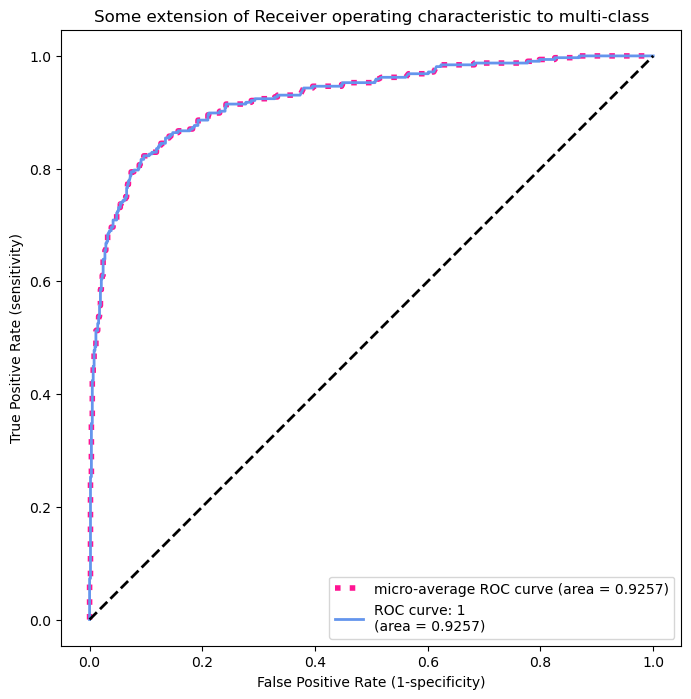

AUROC = 0.9256684112301201
optimal_threshold (micro) = 0.3699616774610467


In [113]:
# plot ROC
def calculate_roc(y_true, y_prob, CLASSES=[1], micro_avg=True, marco_avg=False, ):

    # 分別算出每一類別的 FPR(假陽率) TPR(真陽率) AUC(roc_curve底下的面積)
    N_CLASSES = len(CLASSES)
    y_true = y_true.reshape((-1, N_CLASSES))
    y_prob = y_prob.reshape((-1, N_CLASSES))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds = dict()
    lw = 2
    for i in range(N_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_prob[:, i])  # <--
        roc_auc[i] = auc(fpr[i], tpr[i])

    if micro_avg == True:
        # 計算 微觀平均曲線
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(y_true.ravel(), y_prob.ravel())  # <--
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    if marco_avg == True:
        # 計算 宏觀平均曲線
        # Compute macro-average ROC curve and ROC area

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(N_CLASSES):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= N_CLASSES

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #### 畫出所有 ROC 曲線 ####
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    if micro_avg == True:
        plt.plot(fpr["micro"], tpr["micro"],
                label='micro-average ROC curve (area = {0:0.4f})'
                    ''.format(roc_auc["micro"]),
                color='deeppink', linestyle=':', linewidth=4)

    if marco_avg == True:
        plt.plot(fpr["macro"], tpr["macro"],
                label='macro-average ROC curve (area = {0:0.4f})'
                    ''.format(roc_auc["macro"]),
                color='navy', linestyle=':', linewidth=4)

    colors = cycle(['cornflowerblue', 'green', 'darkorange', 'red'])
    for i, color in zip(range(N_CLASSES), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve: {0}\n(area = {1:0.4f})'
                ''.format(CLASSES[i], roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
    ax.axis('equal')
    ax.set_xlabel('False Positive Rate (1-specificity)')
    ax.set_ylabel('True Positive Rate (sensitivity)')
    ax.set_title('Some extension of Receiver operating characteristic to multi-class')
    ax.legend(loc="lower right")
    plt.show()

    # 平衡點 (micro average)
    optimal_idx = np.argmax(tpr["micro"] - fpr["micro"])
    optimal_threshold = thresholds["micro"][optimal_idx + 1]
    return roc_auc, optimal_threshold

# function test:
roc_auc, optimal_threshold = calculate_roc(y_true_arr, y_prob_arr)
print("AUROC =", roc_auc['micro'])
print("optimal_threshold (micro) =", optimal_threshold)

## classification report

In [114]:
# classification report
print(classification_report(y_true_arr,
                            y_prob_arr > optimal_threshold,
                            target_names=['Noact', 'Act'], digits=4))

              precision    recall  f1-score   support

       Noact     0.9089    0.8958    0.9023       624
         Act     0.8000    0.8228    0.8112       316

    accuracy                         0.8713       940
   macro avg     0.8545    0.8593    0.8568       940
weighted avg     0.8723    0.8713    0.8717       940



## Save models

In [115]:
# save any python object to joblib file
out_file = "SVM_models.joblib"
with open(out_file, 'wb') as f:
    pickle.dump(models_list, f)
print("models_list is saved to:", out_file)

models_list is saved to: SVM_models.joblib


In [116]:
# read python object from joblib file
file_name = "SVM_models.joblib"
with open(file_name, 'rb') as f:
    models_list = pickle.load(f)
print("models_list is restored from:", file_name)

models_list is restored from: SVM_models.joblib


# 3 Test with new data

In [117]:
test_csv_file = "test_dataset_drop05.csv"  # <-- test_data.csv path
df1 = pd.read_csv(test_csv_file).loc[:, 'ID':]
id_col = df1['ID']
df1.head(5)

,ID,name,smiles,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,T1,dizocilpine,C[C@]12N[C@H](Cc3ccccc31)c1ccccc12,0.0,-0.2538,0.064414,19.5988,39.261895,12.0,12.0,...,0.533350,0.289553,0.463899,0.529089,0.444675,9.568739,27.483491,61.013820,0.300025,1.437663
1,T2,digoxin,C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...,0.0,NaN,13.529155,184.4640,126.062752,0.0,0.0,...,0.816047,0.144817,0.613127,0.549468,0.472166,57.561004,516.146782,1455.758251,0.724071,1.634761
2,T3,schembl18285121,C=CCc1cccc(/C=N\NC(=O)CN2CCN(Cc3ccc(S(N)(=O)=O...,0.0,-1.1545,1.332870,77.5195,71.424997,12.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,T4,1-nonene,C=CCCCCCCC,0.0,-0.4256,0.181135,35.0557,27.842274,NaN,0.0,...,0.903078,0.063421,0.530797,0.593252,0.499075,NaN,14.149477,30.516671,0.854617,1.623124
4,T5,1-decene,C=CCCCCCCCC,0.0,-0.7136,0.509225,37.9673,30.935860,0.0,0.0,...,0.918048,0.053185,0.534344,0.606024,0.513754,15.050920,17.389730,37.229557,0.877072,1.654122


In [118]:
constant_columns = ['nB', 'nBondsQ', 'nHsNH3p', 'nHssNH2p', 'nHsssNHp', 'nHmisc', 'nsLi', 'nssBe', 'nssssBem', 'nsBH2', 'nssBH', 'nsssB', 'nssssBm', 'nddC', 'nsNH3p', 'nssNH2p', 'nsssNHp', 'nddsN', 'naOm', 'nsSiH3', 'nssSiH2', 'nsssSiH', 'nssssSi', 'nsPH2', 'nssPH', 'nsssP', 'nddsP', 'nsssssP', 'nssssssS', 'nSm', 'nsGeH3', 'nssGeH2', 'nsssGeH', 'nssssGe', 'nsAsH2', 'nssAsH', 'nsssAs', 'ndsssAs', 'nddsAs', 'nsssssAs', 'nsSeH', 'ndSe', 'nssSe', 'naaSe', 'ndssSe', 'nssssssSe', 'nddssSe', 'nsSnH3', 'nssSnH2', 'nsssSnH', 'nssssSn', 'nsPbH3', 'nssPbH2', 'nsssPbH', 'nssssPb', 'SHsNH3p', 'SHssNH2p', 'SHsssNHp', 'SHmisc', 'SsLi', 'SssBe', 'SssssBem', 'SsBH2', 'SssBH', 'SsssB', 'SssssBm', 'SddC', 'SsNH3p', 'SssNH2p', 'SsssNHp', 'SddsN', 'SaOm', 'SsSiH3', 'SssSiH2', 'SsssSiH', 'SssssSi', 'SsPH2', 'SssPH', 'SsssP', 'SddsP', 'SsssssP', 'SssssssS', 'SSm', 'SsGeH3', 'SssGeH2', 'SsssGeH', 'SssssGe', 'SsAsH2', 'SssAsH', 'SsssAs', 'SdsssAs', 'SddsAs', 'SsssssAs', 'SsSeH', 'SdSe', 'SssSe', 'SaaSe', 'SdssSe', 'SssssssSe', 'SddssSe', 'SsSnH3', 'SssSnH2', 'SsssSnH', 'SssssSn', 'SsPbH3', 'SssPbH2', 'SsssPbH', 'SssssPb', 'minHsNH3p', 'minHssNH2p', 'minHsssNHp', 'minHmisc', 'minsLi', 'minssBe', 'minssssBem', 'minsBH2', 'minssBH', 'minsssB', 'minssssBm', 'minddC', 'minsNH3p', 'minssNH2p', 'minsssNHp', 'minddsN', 'minaOm', 'minsSiH3', 'minssSiH2', 'minsssSiH', 'minssssSi', 'minsPH2', 'minssPH', 'minsssP', 'minddsP', 'minsssssP', 'minssssssS', 'minSm', 'minsGeH3', 'minssGeH2', 'minsssGeH', 'minssssGe', 'minsAsH2', 'minssAsH', 'minsssAs', 'mindsssAs', 'minddsAs', 'minsssssAs', 'minsSeH', 'mindSe', 'minssSe', 'minaaSe', 'mindssSe', 'minssssssSe', 'minddssSe', 'minsSnH3', 'minssSnH2', 'minsssSnH', 'minssssSn', 'minsPbH3', 'minssPbH2', 'minsssPbH', 'minssssPb', 'maxHsNH3p', 'maxHssNH2p', 'maxHsssNHp', 'maxHmisc', 'maxsLi', 'maxssBe', 'maxssssBem', 'maxsBH2', 'maxssBH', 'maxsssB', 'maxssssBm', 'maxddC', 'maxsNH3p', 'maxssNH2p', 'maxsssNHp', 'maxddsN', 'maxaOm', 'maxsSiH3', 'maxssSiH2', 'maxsssSiH', 'maxssssSi', 'maxsPH2', 'maxssPH', 'maxsssP', 'maxdsssP', 'maxddsP', 'maxsssssP', 'maxsSH', 'maxssS', 'maxaaS', 'maxdssS', 'maxddssS', 'maxssssssS', 'maxSm', 'maxsGeH3', 'maxssGeH2', 'maxsssGeH', 'maxssssGe', 'maxsAsH2', 'maxssAsH', 'maxsssAs', 'maxdsssAs', 'maxddsAs', 'maxsssssAs', 'maxsSeH', 'maxdSe', 'maxssSe', 'maxaaSe', 'maxdssSe', 'maxssssssSe', 'maxddssSe', 'maxsSnH3', 'maxssSnH2', 'maxsssSnH', 'maxssssSn', 'maxsPbH3', 'maxssPbH2', 'maxsssPbH', 'maxssssPb', 'n9Ring', 'n10Ring', 'n11Ring', 'n12Ring', 'nF4Ring', 'nF5Ring', 'n9HeteroRing', 'n10HeteroRing', 'n11HeteroRing', 'n12HeteroRing', 'nFHeteroRing', 'nF4HeteroRing', 'nF5HeteroRing', 'nTHeteroRing']

data1 = df1.drop(columns=(['ID', 'name', 'smiles']+constant_columns))
data1.head(5)

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,0.0,-0.2538,0.064414,19.5988,39.261895,12.0,12.0,32.0,17.0,15.0,...,0.533350,0.289553,0.463899,0.529089,0.444675,9.568739,27.483491,61.013820,0.300025,1.437663
1,0.0,NaN,13.529155,184.4640,126.062752,0.0,0.0,119.0,55.0,64.0,...,0.816047,0.144817,0.613127,0.549468,0.472166,57.561004,516.146782,1455.758251,0.724071,1.634761
2,0.0,-1.1545,1.332870,77.5195,71.424997,12.0,12.0,62.0,33.0,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,-0.4256,0.181135,35.0557,27.842274,NaN,0.0,27.0,9.0,18.0,...,0.903078,0.063421,0.530797,0.593252,0.499075,NaN,14.149477,30.516671,0.854617,1.623124
4,0.0,-0.7136,0.509225,37.9673,30.935860,0.0,0.0,30.0,10.0,20.0,...,0.918048,0.053185,0.534344,0.606024,0.513754,15.050920,17.389730,37.229557,0.877072,1.654122


## [TODO] all processes are the same as dev_data

In [ ]:
# feature engineering
# feature impute
# df1.loc[:, 'nAcid':] = df1.loc[:, 'nAcid':].replace([np.inf, -np.inf], np.nan)
# df1.loc[:, 'nAcid':] = df1.loc[:, 'nAcid':].fillna(0)  # just simple fill all NaN with 0

In [119]:
selected_features1 = data1.columns
for column in data1.columns:
    max_value = data[column][data[column] != np.inf].max()  # Calculate the maximum value excluding inf
    data1[column].replace(np.inf, max_value, inplace=True)  # Replace inf with the maximum value

# 使用KNN補值原始資料的NaN
# scaler1 = MinMaxScaler().fit(data1)
scaled_df1 = scaler.transform(data1)

# 使用KNN補值
# knn_imputer1 = KNNImputer(n_neighbors=4).fit(scaled_df1)
knn_imputed_df1 = knn_imputer.transform(scaled_df1)

# 將補值後的資料還原為原始範圍
df1 = scaler.inverse_transform(knn_imputed_df1)
df1 = pd.DataFrame(df1, columns=selected_features1)
df1.head(5)

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,0.0,-0.25380,0.064414,19.5988,39.261895,12.0,12.0,32.0,17.0,15.0,...,0.533350,0.289553,0.463899,0.529089,0.444675,9.568739,27.483491,61.013820,0.300025,1.437663
1,0.0,-2.54225,13.529155,184.4640,126.062752,0.0,0.0,119.0,55.0,64.0,...,0.816047,0.144817,0.613127,0.549468,0.472166,57.561004,516.146782,1455.758251,0.724071,1.634761
2,0.0,-1.15450,1.332870,77.5195,71.424997,12.0,12.0,62.0,33.0,29.0,...,0.763326,0.158151,0.533392,0.444020,0.401937,22.184656,84.542716,180.522092,0.644990,1.379348
3,0.0,-0.42560,0.181135,35.0557,27.842274,1.5,0.0,27.0,9.0,18.0,...,0.903078,0.063421,0.530797,0.593252,0.499075,12.175619,14.149477,30.516671,0.854617,1.623124
4,0.0,-0.71360,0.509225,37.9673,30.935860,0.0,0.0,30.0,10.0,20.0,...,0.918048,0.053185,0.534344,0.606024,0.513754,15.050920,17.389730,37.229557,0.877072,1.654122


## Define model feature inputs(X) and target output(y)

In [120]:
# feature(X)
X_test_raw = df1.loc[:, use_cols].values
print("X_test_raw shape =", X_test_raw.shape, X_test_raw.dtype)

X_test_raw shape = (221, 1641) float64


In [121]:
# feature normalization
# transform X_raw to normalized (X)
X_test = transformer.transform(X_test_raw)
print("Normalized X_test =", X_test)

Normalized X_test = [[0.00000000e+00 5.87194623e-01 3.62817181e-04 ... 8.42808210e-02
  3.09855296e-02 3.31036506e-02]
 [0.00000000e+00 4.84386372e-01 7.62035768e-02 ... 8.96142004e-01
  1.08529662e-01 4.65870656e-02]
 [0.00000000e+00 5.46730819e-01 7.50745172e-03 ... 1.53844911e-01
  9.40683028e-02 2.91143268e-02]
 ...
 [0.00000000e+00 4.66508531e-01 4.86920907e-02 ... 6.27849226e-02
  9.74359543e-02 2.36100973e-02]
 [0.00000000e+00 5.98174254e-01 4.97635358e-07 ... 9.73120263e-02
  5.78241830e-02 1.96298167e-02]
 [0.00000000e+00 6.46791917e-01 6.48249518e-03 ... 1.68902432e-01
  8.12838066e-02 2.39605020e-02]]


## Model prediction

In [122]:
# get predict proba from all models in model_list
predict_list = []
for i, model in enumerate(models_list):
    y_prob = model.predict_proba(X_test)  # pred:[class0, class1]
    print(f"[Model {i+1}] output shape =", y_prob.shape)
    y_prob = y_prob[:, 1]  # use class1 as single output
    predict_list.append(y_prob)
    # break
print("\n Number of predictions:", len(predict_list))

[Model 1] output shape = (221, 2)
[Model 2] output shape = (221, 2)
[Model 3] output shape = (221, 2)
[Model 4] output shape = (221, 2)
[Model 5] output shape = (221, 2)

 Number of predictions: 5


In [123]:
pred_prob = np.stack(predict_list).mean(axis=0)
print("pred_prob shape =", pred_prob.shape)

pred_prob shape = (221,)


## Save submit.csv

In [124]:
# df_submit
df_submit = pd.DataFrame(columns=['ID', 'Pred_prob'])
df_submit['ID'] = id_col
df_submit['Pred_prob'] = pred_prob
df_submit

,ID,Pred_prob
0,T1,0.931662
1,T2,0.057531
2,T3,0.071081
3,T4,0.190770
4,T5,0.167070
...,...,...
216,T217,0.054272
217,T218,0.104384
218,T219,0.087735
219,T220,0.862969


In [125]:
# save submit.csv
df_submit.to_csv("submit.csv", index=False)